In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy
from meteostat import Stations, Daily
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheval.metrics import R2Score
import os

In [4]:
degree_days = 'gw_hdd'

In [ ]:
path = "RawData"


def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time


def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime



ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [ ]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])
passed_rows = []
for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(8, 14):
            changes.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
        new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
        ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
passed_rows

In [ ]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
passed_rows = []
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]

    try:
        ecmwf = ecmwf_df.iloc[8]
        ecmwf_eps = ecmwf_eps_df.iloc[9]
    except IndexError:
        print(f"error on row: {i}")
        passed_rows.append(i)
        continue

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(8,10):
            changes.append(ecmwf_df.iloc[day - offset]['Value'] - ecmwf_eps_df.iloc[day]['Value'])
        new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
        ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
passed_rows

In [ ]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])
passed_rows = []
for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_ens_bc_df = gfs_ens_bc_df[gfs_ens_bc_df[gfs_ens_bc_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    try:
        date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])
        prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    except IndexError:
        print(f"error on row: {i}")
        passed_rows.append(i)
        continue

    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(8, 14):
            changes.append(gfs_ens_bc_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
        new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
        gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
passed_rows

In [ ]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])
passed_rows = []

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    cmc_ens_df = cmc_ens_df[cmc_ens_df[cmc_ens_df.columns[2]] >= 1]
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_ens_bc_df = gfs_ens_bc_df[gfs_ens_bc_df[gfs_ens_bc_df.columns[2]] >= 1]
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    try:
        for day in range(8, 14):
            changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
        new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
        cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
passed_rows

In [ ]:
day_8_error = pd.DataFrame(columns=['day_8_error'])
passed_rows = []

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0
    day = 7
    changes = []
    try:
        changes.append(ecmwf_eps_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day + offset]['Value'])
        new_row = pd.DataFrame([changes], columns=day_8_error.columns, index=[date])
        day_8_error = pd.concat([day_8_error, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
errors_df = pd.DataFrame(columns=['error_9', 'error_10', 'error_11', 'error_12', 'error_13', 'error_14'])
passed_rows = []

for i in range(2, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-2])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    errors = []
    try:
        for day in range(8, 14):
            errors.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
        new_row = pd.DataFrame([errors], columns=errors_df.columns, index=[date])
        errors_df = pd.concat([errors_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

new features

In [ ]:
#add if noon

In [ ]:
errors_df['noon'] = errors_df.index.hour
errors_df['noon'] = errors_df['noon'].apply(lambda x: 1 if x == 12 else 0)

In [ ]:
def f(x):
    y = 1 - (abs(x-7) / 7)
    return y

In [ ]:
errors_df['month'] = errors_df.index.month
#errors_df['month'] = errors_df['month'].apply(lambda x: f(x))

In [ ]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, errors_df, day_8_error, ecmwf_eps_change_df], axis=1)
master_df.fillna(0, inplace=True)
display(master_df[-5:])

In [ ]:
master_df.to_pickle('master_df.pkl')

random forest

In [409]:
master_df = pd.read_pickle('master_df.pkl')

In [ ]:
master_df['ecmwf-eps_9'][-800:].plot()

In [ ]:
X = master_df.iloc[:, :-6]
y = master_df.iloc[:, -6:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

RNN

In [ ]:
input_features = master_df.iloc[:, :-6].values ** 2
target_variables = master_df.iloc[:, -6:].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, target_variables, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

# Scale the input features based on the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation and test data based on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors

X_train_tensor = torch.Tensor(X_train_scaled)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val_scaled)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test_scaled)
y_test_tensor = torch.Tensor(y_test)

In [ ]:
#benchmark error
total_mse = 0
c = 0
for i in range(1, len(y_test_tensor)):
    #mse = mean_squared_error(y_test_tensor[i], y_test_tensor[i-1])
    mse = mean_squared_error(y_test_tensor[i], [0,0,0,0,0,0])
    total_mse += mse
    c += 1

total_mse/c

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, output_size)  # Final output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out)  # Apply ReLU activation between LSTM and first dense layer
        out = self.fc1(out[:, -1, :])
        out = F.relu(out)  # Apply ReLU activation to the output of the first dense layer
        out = self.fc2(out)

        return out

In [ ]:
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 256
num_layers = 3
dropout = 0.3
lr = 0.01
mps_device = torch.device("mps")

In [ ]:
model = RNN(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

In [ ]:
num_epochs = 100
sequence_length = 10  # Number of previous days to consider

best_loss = float('inf')
best_model = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Loop through each sequence in the training data
    for i in range(sequence_length, X_train_tensor.shape[0]):
        # Extract the current sequence and target
        input_seq = X_train_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_train_tensor[i]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / (X_train_tensor.shape[0] - sequence_length)
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}')

    # Validation stage
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0

        for i in range(sequence_length, X_val_tensor.shape[0]):
            input_seq = X_val_tensor[i - sequence_length:i].view(1, sequence_length, -1)
            target_seq = y_val_tensor[i]

            output = model(input_seq)
            val_loss = criterion(output, target_seq.unsqueeze(0))

            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / (X_val_tensor.shape[0] - sequence_length)
        val_losses.append(average_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss}')

        # Check if current model is the best based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_model = copy.deepcopy(model)

# After training, use the best model for testing
model = best_model

In [ ]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
plot_losses(train_losses, val_losses)

In [ ]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for i in range(sequence_length, X_test_tensor.shape[0]):
        input_seq = X_test_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_test_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        test_loss += loss.item()

        # Extract the scalar value from the tensor and append it to predictions
        predictions.append(output.squeeze().tolist())

    average_test_loss = test_loss / (X_test_tensor.shape[0] - sequence_length)
    print(f'Test Loss: {average_test_loss}')

    # Convert the predictions and target values to numpy arrays
    predictions = np.array(predictions)
    targets = y_test_tensor[sequence_length:].numpy()

    # Evaluate the performance using appropriate metrics
    # For example, calculate mean squared error (MSE)
    mse = mean_squared_error(targets, predictions)
    metric = R2Score()
    r2 = metric.update(torch.tensor(predictions), torch.tensor(targets)).compute()
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R2 Score: {r2}')

In [ ]:
def prediction(input):
    model.eval()

    with torch.no_grad():
        input_seq = torch.tensor(input).view(1, sequence_length, -1)
        output = model(input_seq)
        return output.squeeze().tolist()

In [ ]:
pred = prediction(X_test_tensor[-sequence_length:])

In [ ]:
pred

In [ ]:
y_test_tensor[-1]

In [ ]:
if not os.path.exists('master_df.pkl'):
    print('does not exist')
else:
    print('exists')

# Autogloun

In [7]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
import os.path

In [415]:
imp_features = list(set(["day_8_error", "gfs-ens-bc_9", "ecmwf_diff_8", "noon", "cmc-ens_9",
                    "gfs-ens-bc_10", "gfs-ens-bc_9", "ecmwf_diff_9", "cmc-ens_10",
                    "noon", "gfs-ens-bc_10", "gfs-ens-bc_11", "gfs-ens-bc_9",
                    "cmc-ens_11", "gfs-ens-bc_11", "gfs-ens-bc_12", "gfs-ens-bc_10",
                    "gfs-ens-bc_12", "gfs-ens-bc_13"]))

In [8]:
labels = ['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12', 'ecmwf-eps_13',
          'ecmwf-eps_14']

In [417]:
#y = master_df.iloc[:, -6:].copy()
#y = y.reset_index(drop=True)
#X = master_df.iloc[:, :-6].copy()
#X['Date'] = X.index
#X = X.reset_index(drop=True)

In [418]:
#auto_ml_pipeline_feature_generator = AutoMLPipelineFeatureGenerator()
#X = auto_ml_pipeline_feature_generator.fit_transform(X=X)

In [419]:
#df = pd.concat([X, y], axis=1)

In [5]:
master_df = pd.read_pickle(f'master_df_{degree_days}.pkl')

In [9]:
train_len = 0.8
train_data = TabularDataset(master_df[:int(len(master_df)*train_len)])
test_data = TabularDataset(master_df[int(len(master_df)*train_len):])

In [10]:
#train_data = train_data.loc[:, imp_features + labels]
#test_data = test_data.loc[:, imp_features + labels]

In [11]:
save_path = 'models'

In [12]:
display(train_data.head())

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_13,error_14,noon,day_8_error,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.012,0.009,0.006,0.002,0.004,0.011,-0.008,-0.005,-0.001,-0.003,...,0.000,0.000,0.0,0.000,0.000,0.002,0.001,0.000,0.000,0.000
2018-07-11 12:00:00,0.001,0.001,0.004,0.009,0.011,0.013,-0.003,-0.002,-0.004,-0.008,...,0.001,-0.001,1.0,0.005,0.001,0.000,0.000,0.000,-0.001,0.001
2018-07-12 00:00:00,0.010,0.007,0.011,0.013,0.011,0.008,-0.007,-0.011,-0.013,-0.011,...,-0.001,0.000,0.0,0.000,0.000,0.003,0.001,0.000,0.001,0.000
2018-07-12 12:00:00,0.006,0.009,0.010,0.009,0.009,0.009,-0.008,-0.009,-0.009,-0.010,...,0.001,-0.001,1.0,-0.002,-0.003,-0.001,0.001,0.001,0.000,0.000
2018-07-13 00:00:00,0.012,0.007,0.008,0.007,0.009,0.009,-0.007,-0.009,-0.009,-0.010,...,0.001,0.001,0.0,0.000,0.000,0.000,-0.002,-0.002,0.001,0.004


In [28]:
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def feature_imp(self,data, **kwargs):
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.feature_importance(data, **kwargs)
            print(f"Evaluating feature importance for label: {label} ...")
        return eval_dict

    def best_model(self):
        for label in self.labels:
            predictor = self.get_predictor(label)
            best_model = predictor.best_model()
            print(f"Best model for {label}: {best_model}")

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [ ]:
multi_predictor = MultilabelPredictor(labels=labels, path=save_path)

In [ ]:
multi_predictor.fit(train_data) # add presets='best_quality' for better results, but longer runtime

In [ ]:
feature_imp = multi_predictor.feature_imp(train_data)


In [ ]:
print(feature_imp)

In [29]:
multi_predictor = MultilabelPredictor.load(f"models/{degree_days}")
test_data_nolab = test_data.drop(columns=labels)
test_data_nolab.head()

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,ecmwf_diff_8,ecmwf_diff_9,error_9,error_10,error_11,error_12,error_13,error_14,noon,day_8_error
2022-06-03 00:00:00,-0.324,-0.276,-0.110,-0.182,-0.039,0.143,0.272,0.178,0.121,0.060,...,-0.456,-0.438,-0.122,0.004,0.088,0.016,-0.049,-0.072,0.0,-0.137
2022-06-03 12:00:00,-0.233,-0.238,-0.207,-0.074,0.055,0.106,-0.070,-0.170,-0.144,-0.096,...,-0.433,-0.322,-0.128,-0.068,0.026,0.021,0.002,0.007,1.0,-0.055
2022-06-04 00:00:00,-0.164,-0.103,-0.039,0.044,0.033,0.025,0.201,-0.113,-0.270,-0.269,...,-0.194,0.044,-0.064,-0.042,-0.085,-0.028,0.021,0.030,0.0,0.034
2022-06-04 12:00:00,-0.224,-0.029,-0.032,-0.087,-0.065,0.020,-0.119,-0.236,-0.202,-0.056,...,-0.554,-0.198,0.032,0.000,0.036,0.072,0.047,0.033,1.0,-0.191
2022-06-05 00:00:00,0.238,0.247,0.328,0.372,0.151,-0.013,-0.160,-0.389,-0.462,-0.334,...,0.011,-0.020,-0.189,-0.179,-0.218,-0.228,-0.159,-0.049,0.0,0.387


In [30]:
predictions = multi_predictor.predict(test_data_nolab)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: ecmwf-eps_9 ...
Predicting with TabularPredictor for label: ecmwf-eps_10 ...
Predicting with TabularPredictor for label: ecmwf-eps_11 ...
Predicting with TabularPredictor for label: ecmwf-eps_12 ...
Predicting with TabularPredictor for label: ecmwf-eps_13 ...
Predicting with TabularPredictor for label: ecmwf-eps_14 ...
Predictions:  
                      ecmwf-eps_9  ecmwf-eps_10  ecmwf-eps_11  ecmwf-eps_12  \
2022-06-03 00:00:00    -0.113043     -0.093989     -0.040122     -0.094332   
2022-06-03 12:00:00    -0.168873     -0.186023     -0.154304     -0.044776   
2022-06-04 00:00:00     0.027795      0.059410     -0.055787     -0.111990   
2022-06-04 12:00:00    -0.290591     -0.158507     -0.082526     -0.040561   
2022-06-05 00:00:00     0.372010      0.203796      0.045132     -0.019628   
...                          ...           ...           ...           ...   
2023-05-15 00:00:00     0.990041      1.010637      0.520393      0.35782

In [31]:
multi_predictor.best_model()

AttributeError: 'MultilabelPredictor' object has no attribute 'best_model'

In [17]:
display(predictions.iloc[-1])

ecmwf-eps_9     0.464949
ecmwf-eps_10    0.282491
ecmwf-eps_11    0.043154
ecmwf-eps_12   -0.081446
ecmwf-eps_13   -0.312049
ecmwf-eps_14   -0.232576
Name: 2023-05-17 00:00:00, dtype: float32

In [18]:
display(test_data[labels].iloc[-1])

ecmwf-eps_9     0.482
ecmwf-eps_10    0.299
ecmwf-eps_11    0.191
ecmwf-eps_12   -0.095
ecmwf-eps_13   -0.359
ecmwf-eps_14   -0.209
Name: 2023-05-17 00:00:00, dtype: float64

In [19]:
evaluations = multi_predictor.evaluate(test_data)
#print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

Evaluating TabularPredictor for label: ecmwf-eps_9 ...


Evaluating TabularPredictor for label: ecmwf-eps_10 ...


Evaluating TabularPredictor for label: ecmwf-eps_11 ...


Evaluating TabularPredictor for label: ecmwf-eps_12 ...


Evaluating TabularPredictor for label: ecmwf-eps_13 ...


Evaluating TabularPredictor for label: ecmwf-eps_14 ...


Evaluated using metrics: {'ecmwf-eps_9': root_mean_squared_error, 'ecmwf-eps_10': root_mean_squared_error, 'ecmwf-eps_11': root_mean_squared_error, 'ecmwf-eps_12': root_mean_squared_error, 'ecmwf-eps_13': root_mean_squared_error, 'ecmwf-eps_14': root_mean_squared_error}


In [20]:
evaluations

{'ecmwf-eps_9': {'root_mean_squared_error': -0.5049367730669845,
  'mean_squared_error': -0.25496114479529935,
  'mean_absolute_error': -0.2866119572260672,
  'r2': 0.8965555647961793,
  'pearsonr': 0.9478862630558099,
  'median_absolute_error': -0.09294725799560766},
 'ecmwf-eps_10': {'root_mean_squared_error': -0.7607167953716851,
  'mean_squared_error': -0.5786900427605662,
  'mean_absolute_error': -0.5056945373078746,
  'r2': 0.7424533708025796,
  'pearsonr': 0.8624216315920347,
  'median_absolute_error': -0.32475531387329326},
 'ecmwf-eps_11': {'root_mean_squared_error': -0.9294480842767239,
  'mean_squared_error': -0.863873741365672,
  'mean_absolute_error': -0.6210500643808698,
  'r2': 0.5359056436988701,
  'pearsonr': 0.7347066753761877,
  'median_absolute_error': -0.3573926563262939},
 'ecmwf-eps_12': {'root_mean_squared_error': -0.9785228288550571,
  'mean_squared_error': -0.9575069265905035,
  'mean_absolute_error': -0.658803275483605,
  'r2': 0.3807210291469205,
  'pearsonr

{'ecmwf-eps_9': {'root_mean_squared_error': -0.5070563022070824,
  'mean_squared_error': -0.25710609360792014,
  'mean_absolute_error': -0.2798848657393207,
  'r2': 0.8956853027072607,
  'pearsonr': 0.9477558158265489,
  'median_absolute_error': -0.08431462287902924},
 'ecmwf-eps_10': {'root_mean_squared_error': -0.7801987677851059,
  'mean_squared_error': -0.6087101172533975,
  'mean_absolute_error': -0.5127994778988779,
  'r2': 0.7290929041925068,
  'pearsonr': 0.8539896408843493,
  'median_absolute_error': -0.3007085895538335},
 'ecmwf-eps_11': {'root_mean_squared_error': -0.9673184506563108,
  'mean_squared_error': -0.9357049849801256,
  'mean_absolute_error': -0.6515933946707977,
  'r2': 0.4973161216758266,
  'pearsonr': 0.7102926086311597,
  'median_absolute_error': -0.3967944383621216},
 'ecmwf-eps_12': {'root_mean_squared_error': -0.9975580503693926,
  'mean_squared_error': -0.9951220638567836,
  'mean_absolute_error': -0.6839024679556679,
  'r2': 0.35639299260967516,
  'pearsonr': 0.6123533275180042,
  'median_absolute_error': -0.3845637946128857},
 'ecmwf-eps_13': {'root_mean_squared_error': -0.9652024686896034,
  'mean_squared_error': -0.9316158055645049,
  'mean_absolute_error': -0.6578454494274173,
  'r2': 0.2667709048317418,
  'pearsonr': 0.5357525489886675,
  'median_absolute_error': -0.3887484552860272},
 'ecmwf-eps_14': {'root_mean_squared_error': -0.9526157480747444,
  'mean_squared_error': -0.9074767634800048,
  'mean_absolute_error': -0.6393496713255836,
  'r2': 0.1672716604026533,
  'pearsonr': 0.4348277794095413,
  'median_absolute_error': -0.42026434469222984}}

In [ ]:
predictor_class = multi_predictor.get_predictor('ecmwf-eps_9')
display(predictor_class.leaderboard(silent=True))

# feature importance / training models for individual days

In [ ]:
from collections import Counter

In [ ]:
most_important = []

for i in range(0, 5):
    day = i
    train_df = train_data.iloc[:, :-5+day]
    test_df = test_data.iloc[:, :-5+day]
    #display(train_df.head())
    label = f"ecmwf-eps_{day+9}"
    predictor = TabularPredictor(label=label).fit(train_df)
    y_test = test_df[label]
    test_data_nolab = test_df.drop(columns=[label])
    print(f"results for {label}")
    y_pred = predictor.predict(test_data_nolab)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    shap_values = predictor.feature_importance(test_df)
    display(shap_values)
    most_important.append(list(shap_values.index[:6].values))

In [ ]:
item_counts = Counter([item for sublist in most_important for item in sublist])
important_features = []
for item, count in item_counts.items():
    print(f'{item}: {count}')
    important_features.append(item)

In [410]:
import autogluon.eda.auto as auto

In [436]:
day = 4
train_df = train_data.iloc[:, :-5+day]
test_df = test_data.iloc[:, :-5+day]
#display(train_df.head())
label = f"ecmwf-eps_{day+9}"

No path specified. Models will be saved in: "AutogluonModels/ag-20230613_202506/"


### Model Prediction for ecmwf-eps_13

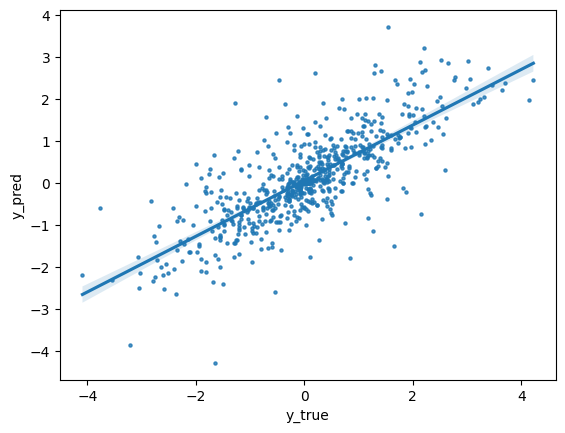

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.719006,-0.570286,0.042877,0.024953,1.022444,0.042877,0.024953,1.022444,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
ecmwf-eps_12,0.841610,0.032305,2.599856e-07,5,0.908126,0.775094
ecmwf-eps_11,0.176427,0.011557,2.197314e-06,5,0.200224,0.152630
gfs-ens-bc_13,0.075929,0.006600,6.780215e-06,5,0.089518,0.062341
gfs-ens-bc_12,0.022262,0.002338,1.438951e-05,5,0.027076,0.017447
gfs-ens-bc_11,0.017697,0.003918,2.704938e-04,5,0.025765,0.009629
ecmwf-eps_10,0.005887,0.002225,2.045559e-03,5,0.010469,0.001304
gfs-ens-bc_10,0.003580,0.001116,1.000265e-03,5,0.005878,0.001282
ecmwf_diff_9,0.000411,0.001487,2.848717e-01,5,0.003473,-0.002650
noon,0.000357,0.000251,1.670366e-02,5,0.000873,-0.000159
cmc-ens_9,-0.000645,0.000990,8.905162e-01,5,0.001393,-0.002682


### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,cmc-ens_9,cmc-ens_10,day_8_error,cmc-ens_11,ecmwf_diff_8,gfs-ens-bc_9,gfs-ens-bc_10,noon,gfs-ens-bc_13,ecmwf_diff_9,gfs-ens-bc_11,gfs-ens-bc_12,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_13_pred,error
2022-02-06 12:00:00,-2.169,0.281,-2.955,2.859,-8.182,-1.597,-2.352,1.0,-0.651,0.546,1.204,1.252,-4.629,-4.618,-0.272,1.650,-1.284,1.893866,3.177866
2020-01-03 00:00:00,-1.414,-3.549,0.758,-5.930,0.165,2.535,0.397,0.0,-0.902,0.271,1.593,3.643,0.758,0.550,1.590,0.037,-3.771,-0.597622,3.173378
2020-03-10 00:00:00,1.510,0.417,4.156,1.504,4.325,3.176,2.127,0.0,-2.702,1.678,1.127,-1.377,4.156,2.971,0.747,-0.543,1.650,-1.506211,3.156211
2021-02-17 00:00:00,2.828,5.680,-1.623,4.834,-1.580,-1.564,-2.852,0.0,-0.707,-1.456,-2.055,-1.315,-1.623,-0.712,2.615,2.844,-0.471,2.446231,2.917231
2019-01-19 00:00:00,-4.741,-3.618,-0.624,-1.874,2.189,0.087,0.723,0.0,1.922,-3.242,-1.416,-0.154,-0.624,-0.367,-3.291,-2.020,2.142,-0.751279,2.893279
2020-01-04 00:00:00,-6.414,-4.487,-3.425,-2.520,-2.156,-2.066,3.375,0.0,-2.247,-2.425,3.207,-2.707,-3.425,0.049,0.854,-3.762,-1.650,-4.291337,2.641337
2020-01-05 00:00:00,-1.264,-2.038,1.063,-5.020,0.184,3.691,1.709,0.0,0.659,0.832,-3.615,-2.620,1.063,0.646,-4.405,-3.328,0.843,-1.788614,2.631614
2020-02-11 00:00:00,-1.905,-2.256,-3.760,-1.057,-5.698,-1.838,-1.439,0.0,-3.041,-0.603,-0.189,-1.032,-3.760,-0.879,2.247,1.243,-1.999,0.458089,2.457089
2022-01-23 12:00:00,3.614,2.316,-0.636,2.636,-3.794,-0.321,-1.654,1.0,3.336,-2.193,-0.968,2.202,0.604,-1.370,-0.968,1.939,0.203,2.609177,2.406177
2022-01-02 00:00:00,5.027,6.200,-5.433,6.095,-5.187,-6.184,-5.559,0.0,-0.027,-0.656,-0.791,0.742,-5.433,-1.951,0.108,-1.123,-2.834,-0.431653,2.402347


In [437]:
state = auto.quick_fit(train_df, label, return_state=True, save_model_to_state=True)

### most important features
ecmwf-eps_9:
- day_8_error
- gfs-ens-bc_9
- ecmwf_diff_8
- noon
- cmc-ens_9

ecmwf-eps_10:
- ecmwf-eps_9
- gfs-ens-bc_10
- gfs-ens-bc_9
- ecmwf_diff_9
- cmc-ens_10
- noon

ecmwf-eps_11:
- ecmwf-eps_10
- gfs-ens-bc_10
- gfs-ens-bc_11
- ecmwf-eps_9
- gfs-ens-bc_9
- cmc-ens_11

ecmwf-eps_12:
- ecmwf-eps_11
- gfs-ens-bc_11
- gfs-ens-bc_12
- ecmwf-eps_10
- gfs-ens-bc_10

ecmwf-eps_13:
- ecmwf-eps_12
- gfs-ens-bc_12
- ecmwf-eps_11
- gfs-ens-bc_13
- ecmwf-eps_10





